In [187]:
import numpy as np
import torch
from sudoku import Sudoku
from matplotlib import pyplot as plt
import deepsudoku as ds
from deepsudoku.utils import data_utils, sudoku_utils

In [190]:
with open("data/natural_distribution.np", 'rb') as f:
    probabilities = np.load(f)

probabilities

array([1.08621311e+00, 1.01670730e+00, 1.01523757e+00, 9.53729212e-01,
       9.24424350e-01, 8.82796705e-01, 8.45308959e-01, 7.88433313e-01,
       7.71946907e-01, 7.17942238e-01, 6.96761370e-01, 6.20256186e-01,
       5.76400816e-01, 5.68345070e-01, 4.95716244e-01, 4.70918119e-01,
       4.52591568e-01, 4.10496563e-01, 3.81083727e-01, 3.56572211e-01,
       3.25206786e-01, 3.28435600e-01, 2.87941068e-01, 2.62831360e-01,
       2.46000335e-01, 1.95438281e-01, 2.05528751e-01, 1.80869520e-01,
       1.82191581e-01, 1.16823517e-01, 1.09197602e-01, 1.40262216e-01,
       7.85043538e-02, 1.19147971e-01, 5.96637204e-02, 4.64704782e-02,
       4.43227291e-02, 4.70444113e-02, 4.71133813e-02, 2.95216721e-02,
       3.60569805e-02, 1.06628044e-02, 2.33673956e-02, 2.81812716e-02,
       1.56739615e-02, 9.05116089e-03, 1.34985168e-02, 5.26945852e-03,
       6.08425261e-03, 4.95631155e-03, 2.34988588e-03, 9.89251770e-04,
       2.34781811e-03, 4.68123326e-04, 3.93926690e-04, 2.18065735e-03,
      

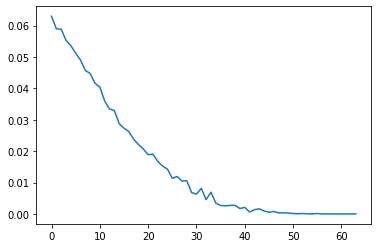

In [192]:
plt.plot(probabilities/sum(probabilities))

In [159]:
model = ds.model.SimpleNet()

In [160]:
model.load_state_dict(torch.load("documentation/2.pth", map_location=torch.device('cpu'))["model_state_dict"])

<All keys matched successfully>

In [161]:
train_sudokus, val_sudokus, test_sudokus = data_utils.load_data()

In [162]:
loss_fn = torch.nn.CrossEntropyLoss()


In [164]:
def natural_distribution():
    possible_numbers_of_moves_to_make = list(range(0,64))
    with open("data/natural_distribution.np", 'rb') as f:
        probabilities = np.load(f)
    probabilities = probabilities/sum(probabilities)
    return possible_numbers_of_moves_to_make, probabilities

train_sudokus = data_utils.make_moves(train_sudokus, natural_distribution)
val_sudokus = data_utils.make_moves(val_sudokus, natural_distribution)
test_sudokus = data_utils.make_moves(test_sudokus, natural_distribution)


In [165]:
x_test, y_test = data_utils.generate_batch(test_sudokus, augment = False)
x_test = torch.tensor(x_test.reshape(-1,1,9,9).astype('float32'))
y_test = torch.tensor(y_test - 1).type(torch.LongTensor)

In [166]:
dictionary = {}
for i, test_sudoku in enumerate(test_sudokus):
    current_zeros = len(np.argwhere(test_sudoku[0] == 0))
    if current_zeros in dictionary.keys():
        dictionary[current_zeros] += [i]
    else:
        dictionary[current_zeros] = [i]

In [167]:
model.eval()

SimpleNet(
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convs): ModuleList(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (convlast): Conv2d(64, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [168]:
test_losses_i = []
test_accs_i = []

for i in set(dictionary.keys()):

    x_test_i = x_test[dictionary[i]]
    y_test_i = y_test[dictionary[i]]

    with torch.no_grad():
        y_pred_test_i = model(x_test_i)
        test_loss_i = loss_fn(y_pred_test_i, y_test_i)
        indices = torch.max(y_pred_test_i, 1)[1]
        correct = torch.eq(indices, y_test_i).view(-1)
        test_acc_i = torch.sum(correct)/correct.shape[0]

    test_losses_i.append(test_loss_i.item())
    test_accs_i.append(test_acc_i.cpu())

In [169]:
test_accs_i_1 = test_accs_i

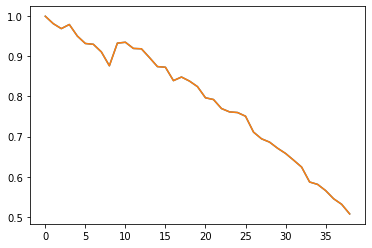

In [170]:
plt.plot(test_accs_i)
plt.plot(test_accs_i_1)

In [ ]:
plt.plot(test)

In [ ]:
test_losses_i = []
test_accs_i = []

for i in set(dictionary.keys()):

    x_test_i = x_test[dictionary[i]]
    y_test_i = y_test[dictionary[i]]

    with torch.no_grad():
        y_pred_test_i = model(x_test_i)
        test_loss_i = loss_fn(y_pred_test_i, y_test_i)
        indices = torch.max(y_pred_test_i, 1)[1]
        correct = torch.eq(indices, y_test_i).view(-1)
        test_acc_i = torch.sum(correct)/correct.shape[0]

    test_losses_i.append(test_loss_i.item())
    test_accs_i.append(test_acc_i.cpu())

In [ ]:
def get_index_of_max_value(sudoku_probabilities):
    max_probabilities_cells, cell_values = torch.max(y_pred_test_i, 1)
    return max_probabilities_cells, cell_values

def get_position_of_max_value(sudoku_probabilities):
    return np.unravel_index(np.argmax(sudoku_probabilities.cpu()), (9,9))


In [174]:
y_pred_test_i.shape

torch.Size([35, 9, 9, 9])

In [175]:
a = y_pred_test_i[0]
print(a.shape)
max_probabilities_cells, cell_values = torch.max(a, 0)
print(max_probabilities_cells.shape)
pos = np.unravel_index(np.argmax(max_probabilities_cells.cpu()), (9,9))
print(max_probabilities_cells)
print(pos)
print(cell_values[pos[0], pos[1]])

torch.Size([9, 9, 9])
torch.Size([9, 9])
tensor([[ 2.0897,  1.4640,  3.5531,  2.4457,  9.5871,  2.3189,  9.4345,  1.7529,
          2.5652],
        [ 2.2968,  1.9882,  2.9126,  2.5381,  1.6832,  0.7733, 10.8117,  2.2543,
         11.3339],
        [ 3.2199,  2.2477, 17.7596,  2.7602,  3.5731,  9.6651,  2.2462,  1.3569,
          2.6005],
        [13.2220, 12.5616,  2.8881, 26.0387,  3.1291,  1.5245,  1.7106,  1.4917,
          1.2776],
        [ 2.4873,  0.7954,  1.9423,  3.2668, 13.8108,  3.1332,  2.8760, 10.5735,
          2.0747],
        [ 4.4942, 15.4122,  1.5469,  2.3014,  1.8145,  1.4093,  1.2668,  2.0063,
          0.5846],
        [11.5725,  1.4883,  1.2240, 13.1751,  0.8367,  1.6471,  1.0478,  1.4733,
          0.5138],
        [ 3.3198,  2.7266, 12.2016,  1.7393,  1.0411,  1.5434,  2.0387,  9.7304,
          1.7891],
        [ 3.1259,  1.9787,  2.3402, 10.9949,  1.1136,  2.6576,  1.8599,  2.0254,
          1.5456]])
(3, 3)
tensor(3)


In [185]:
most_confident_correct_ratio_i = []

for i in set(dictionary.keys()):

    x_test_i = x_test[dictionary[i]]
    y_test_i = y_test[dictionary[i]]
    
    with torch.no_grad():
        y_pred_test_i = model(x_test_i)
        y_pred_test_i_softmax = torch.softmax(y_pred_test_i, 1)
        values, indices = torch.max(y_pred_test_i_softmax*(x_test_i==0), 1)

        correct = 0

        for j, (value, index) in enumerate(zip(values,indices)):
            pos = get_position_of_max_value(value)
            correct += index[pos[0], pos[1]] == y_test_i[j, pos[0], pos[1]]

    most_confident_correct_ratio_i.append((correct/len(values)).cpu())

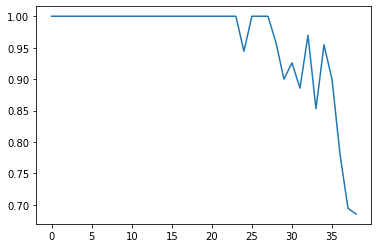

In [186]:
plt.plot(most_confident_correct_ratio_i)

In [182]:
i = 2

sudoku = x_test_i[i].clone()
solution = y_test_i[i].clone()

while len(np.where(sudoku == 0)[0]) > 0:
    with torch.no_grad():
        pred = model(sudoku)
        pred = torch.softmax(pred, 0)
        value, index = torch.max(pred, 0)

    pos = get_position_of_max_value(value*(sudoku == 0))
    sudoku[0, pos[0], pos[1]] = index[pos[0], pos[1]] + 1
    print(f'Confidence: {value[pos[0], pos[1]]:.2f}, true: {index[pos[0], pos[1]] == solution[pos[0], pos[1]]:.2f}')

sudoku == solution + 1

Confidence: 0.81, true: 1.00
Confidence: 0.72, true: 0.00
Confidence: 0.72, true: 0.00
Confidence: 0.70, true: 1.00
Confidence: 0.72, true: 1.00
Confidence: 0.67, true: 1.00
Confidence: 0.69, true: 0.00
Confidence: 0.98, true: 0.00
Confidence: 0.98, true: 1.00
Confidence: 0.95, true: 1.00
Confidence: 0.76, true: 0.00
Confidence: 0.81, true: 1.00
Confidence: 0.99, true: 1.00
Confidence: 0.74, true: 1.00
Confidence: 0.73, true: 1.00
Confidence: 0.78, true: 1.00
Confidence: 0.73, true: 1.00
Confidence: 0.98, true: 1.00
Confidence: 0.94, true: 0.00
Confidence: 0.99, true: 0.00
Confidence: 0.83, true: 1.00
Confidence: 0.82, true: 1.00
Confidence: 0.87, true: 0.00
Confidence: 0.83, true: 1.00
Confidence: 0.79, true: 1.00
Confidence: 0.78, true: 1.00
Confidence: 0.96, true: 0.00
Confidence: 0.85, true: 0.00
Confidence: 0.94, true: 1.00
Confidence: 0.98, true: 0.00
Confidence: 1.00, true: 1.00
Confidence: 0.99, true: 1.00
Confidence: 0.91, true: 0.00
Confidence: 1.00, true: 0.00
Confidence: 1.

tensor([[[False, False, False, False,  True,  True,  True,  True,  True],
         [ True,  True, False,  True,  True, False,  True, False, False],
         [ True, False, False, False,  True,  True,  True,  True,  True],
         [False, False, False,  True,  True, False,  True,  True,  True],
         [ True,  True,  True, False,  True, False,  True, False, False],
         [ True,  True,  True, False,  True, False, False, False, False],
         [False,  True,  True,  True,  True,  True,  True, False,  True],
         [ True,  True,  True, False,  True, False, False,  True,  True],
         [ True,  True, False,  True,  True,  True,  True, False, False]]])

In [153]:
x_test_i[2]

tensor([[[8., 2., 5., 7., 6., 9., 4., 1., 3.],
         [3., 4., 1., 8., 2., 5., 7., 6., 9.],
         [7., 9., 6., 3., 1., 4., 8., 2., 5.],
         [5., 8., 2., 6., 4., 3., 9., 5., 7.],
         [1., 6., 7., 9., 8., 1., 3., 4., 2.],
         [9., 3., 4., 2., 7., 5., 1., 8., 6.],
         [6., 5., 3., 1., 9., 7., 6., 8., 4.],
         [8., 7., 1., 4., 5., 6., 2., 9., 3.],
         [4., 2., 9., 8., 3., 2., 5., 7., 1.]]])

In [96]:
index[pos[0], pos[1]] == solution[pos[0], pos[1]]

tensor(True)

In [83]:
with torch.no_grad():
    pred = model(sudoku)
    value, index = torch.max(pred, 0)

In [114]:
while len(np.where(sudoku == 0)[0]) > 0:
    print(sudoku)
    with torch.no_grad():
        pred = model(sudoku)
        value, index = torch.max(pred, 0)
    print(index[pos[0], pos[1]] == solution[pos[0], pos[1]])
    print(pos)
    print(index[pos[0], pos[1]])
    sudoku[0, pos[0], pos[1]] = index[pos[0], pos[1]] + 1

tensor([[[0., 3., 4., 1., 7., 0., 2., 8., 9.],
         [1., 9., 2., 3., 8., 5., 6., 4., 7.],
         [7., 0., 8., 0., 9., 2., 0., 0., 0.],
         [6., 5., 1., 9., 2., 4., 8., 7., 3.],
         [9., 0., 3., 7., 1., 8., 5., 6., 0.],
         [4., 8., 7., 6., 0., 3., 9., 0., 1.],
         [2., 7., 6., 0., 3., 9., 4., 1., 8.],
         [3., 4., 0., 8., 0., 1., 7., 5., 2.],
         [8., 1., 0., 2., 4., 7., 3., 0., 6.]]])
tensor(True)
(3, 5)
tensor(3)
tensor([[[0., 3., 4., 1., 7., 0., 2., 8., 9.],
         [1., 9., 2., 3., 8., 5., 6., 4., 7.],
         [7., 0., 8., 0., 9., 2., 0., 0., 0.],
         [6., 5., 1., 9., 2., 4., 8., 7., 3.],
         [9., 0., 3., 7., 1., 8., 5., 6., 0.],
         [4., 8., 7., 6., 0., 3., 9., 0., 1.],
         [2., 7., 6., 0., 3., 9., 4., 1., 8.],
         [3., 4., 0., 8., 0., 1., 7., 5., 2.],
         [8., 1., 0., 2., 4., 7., 3., 0., 6.]]])
tensor(True)
(3, 5)
tensor(3)
tensor([[[0., 3., 4., 1., 7., 0., 2., 8., 9.],
         [1., 9., 2., 3., 8., 5., 6., 4., 7

KeyboardInterrupt: 

In [ ]:
values

In [ ]:
values[0, np.argwhere(sudoku[0] != 0)]

In [ ]:
values